In [254]:
%matplotlib inline
import karabo_data as kd
import pandas as pd
from Assembler import Assemble
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys,os
import warnings
warnings.filterwarnings("ignore")
from matplotlib import animation
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [23]:
run_dir = '/gpfs/exfel/exp/SPB/201830/p900022/proc/r0025/'
cr_geomf = os.path.join(os.environ['HOME'], 'xfel2017b-vds-taw3.geom')
df = pd.read_csv('xoffsets')

In [51]:
Run = kd.RunDirectory(run_dir)

In [11]:
def clip(array, vmin=-10000, vmax=10000):
    x = array.copy()
    finite = np.isfinite(x)
    # Suppress warnings comparing numbers to nan
    with np.errstate(invalid='ignore'):
        x[finite & (x < vmin)] = np.nan
        x[finite & (x > vmax)] = np.nan
    return x

In [256]:
def plot(arry, vmin=0, vmax=500,cmap=cm.summer, init=True):
    ary1, ary2, ary3 = arry[0], arry[1], arry[2]
    cmap.set_under('k')
    cmap.set_bad('k')
    ymax = max([ary1.shape[0], ary2.shape[0], ary3.shape[0]])+16
    ymin = min([ary1.shape[0], ary2.shape[0], ary3.shape[0]])
    
    xmax = max([ary1.shape[1], ary2.shape[1], ary3.shape[1]])+16
    xmin = min([ary1.shape[1], ary2.shape[1], ary3.shape[1]])
    
    
    fig, (ax2, ax3) = plt.subplots(1,2, figsize=(17,12))
    fig.subplots_adjust(bottom=0.1, top=.6, wspace=0.1, hspace=0.1)
    for ary, ax in ((ary2, ax2), (ary3, ax3)):
        Y, X = np.arange(ary.shape[0]), np.arange(ary.shape[1])
        im = ax.pcolormesh(X,Y, ary, vmin=vmin, vmax=vmax, cmap=cmap)
        #ax.set_ylim(xmin,xmax)
        #ax.set_xlim(xmax,ymax)
        
    
    #ax1.set_title('Without Geometry')
    ax2.set_title('Crude Geometry')
    ax3.set_title('CrystFel Geometry')
    cbar_ax = fig.add_axes([0.17, 0.05, 0.65, 0.01])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

In [231]:

C = Assemble(df)
G = Assemble(cr_geomf)
npulses, maxtrains = 0, 100

ii = 0
for tId, data in Run.trains():
    sys.stdout.flush()
    sys.stdout.write('\rReading train# %10i  '%tId)
    sys.stdout.flush()
    if len(data.keys()):
        stack_mean = [tId,np.nanmean(C.stack(data), axis=0)]
        naive_mean = [tId,np.nanmean(C.apply_geo(data), axis=0)]
        cr_mean = [tId,np.nanmean(G.apply_geo(data), axis=0)]
        break
    else:
        ii += 1

Reading train#   79549771  

In [243]:
#%%capture
cmap = cm.summer
cmap.set_under('k')
cmap.set_bad('k')
vmin, vmax = 0, 500
fig, (ax2, ax3) = plt.subplots(1,2, figsize=(17,12))
fig.subplots_adjust(bottom=0.3, top=.99, wspace=0.1, hspace=0.1)
plt.suptitle('TrainId # %i'%naive_mean[0])
#plt.gca().set_title(('TrainId # %i'%naive_mean[0]))
#im1 = ax1.imshow(clip(np.empty_like(stack_mean.T)), vmin=vmin, vmax=vmax, cmap=cmap)
im2 = ax2.imshow(clip(np.empty_like(naive_mean[-1])), vmin=vmin, vmax=vmax, cmap=cmap)
im3 = ax3.imshow(clip(np.empty_like(cr_mean[-1])), vmin=vmin, vmax=vmax, cmap=cmap)
plt.close(fig)
#ax1.set_title('Without Geometry')
ax2.set_title('Crude Geometry')
ax3.set_title('CrystFel Geometry')

im = [im2, im3]
cbar_ax = fig.add_axes([0.17, 0.28, 0.65, 0.01])
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
nt = 1
def data_gen():
    i = data_gen.i
    end = 700
    while i < end:
        try:
            tId, data = Run.train_from_index(i)
            if len(data.keys()):
                stack_array = [tId,np.nanmean(C.stack(data), axis=0)]
                naive_array = [tId,np.nanmean(C.apply_geo(data), axis=0)]
                cr_array = [tId,np.nanmean(G.apply_geo(data), axis=0)]
                try:
                    stack_mean += np.ma.masked_invalid(stack_array[-1])
                    naive_mean += np.ma.masked_invalid(naive_array[-1])
                    cr_mean += np.ma.masked_invalid(cr_array[-1])
                except NameError:
                    stack_mean = np.ma.masked_invalid(stack_array[-1])
                    naive_mean = np.ma.masked_invalid(naive_array[-1])
                    cr_mean = np.ma.masked_invalid(cr_array[-1])
                data_gen.np += len(stack_array[-1])
                
                yield stack_array, naive_array, cr_array, stack_mean, naive_mean, cr_array
            i+= 1
            data_gen.i = i
        except IndexError:
            break
            
data_gen.i, data_gen.np = 29, 0
def animate(data):
    stack, naive, cr_array, stack_m, naive_m, cr_m = data
    #im[0].set_array(stack)
    plt.suptitle('TrainId # %i'%naive[0])            
    #plt.gca().set_title(('TrainId # %i'%naive_mean[0]))
    im[0].set_array(naive[-1]) 
    im[1].set_array(cr_array[-1])
    return im
#call the animator.  blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, animate, data_gen, interval=20, blit=True)
anim = animation.FuncAnimation(fig, animate, data_gen, interval=10, blit=True, repeat=False)
# call our new function to display the animation
HTML(anim.to_jshtml())
#plt.show()

<Figure size 432x288 with 0 Axes>

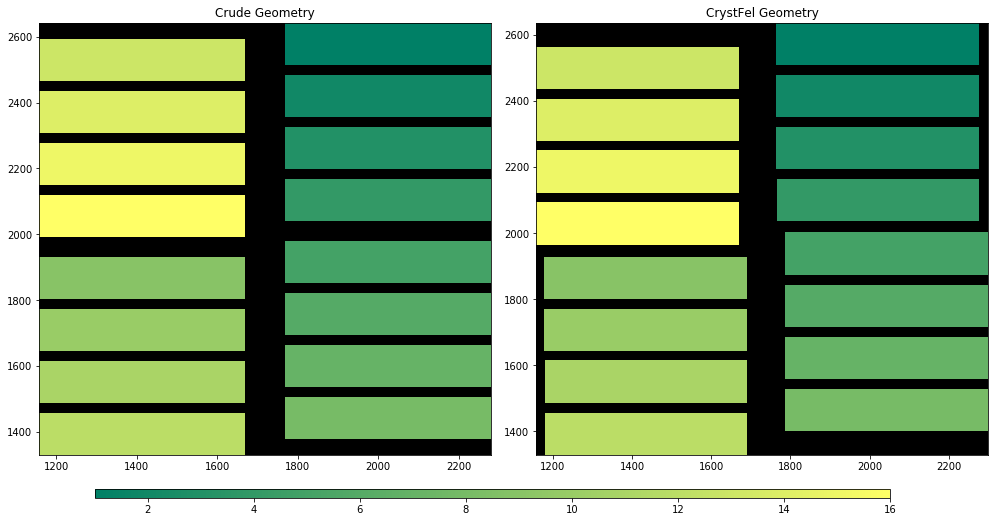

In [209]:
plot([np.flip(stack_mean.T,axis=-1), naive_mean, cr_mean], vmin=1, vmax=16)

In [177]:
naive_mean.shape

(1124, 64)

In [107]:
G.df

,Source,Xoffset,Yoffset,FlipX,FlipY,rotate
0,SPB_DET_AGIPD1M-1/DET/0CH0:xtdf,625,607,True,True,0
1,SPB_DET_AGIPD1M-1/DET/1CH0:xtdf,468,607,True,True,0
2,SPB_DET_AGIPD1M-1/DET/2CH0:xtdf,311,607,True,True,0
3,SPB_DET_AGIPD1M-1/DET/3CH0:xtdf,154,608,True,True,0
4,SPB_DET_AGIPD1M-1/DET/4CH0:xtdf,-9,630,True,True,0
5,SPB_DET_AGIPD1M-1/DET/5CH0:xtdf,-167,630,True,True,0
6,SPB_DET_AGIPD1M-1/DET/6CH0:xtdf,-324,630,True,True,0
7,SPB_DET_AGIPD1M-1/DET/7CH0:xtdf,-482,630,True,True,0
8,SPB_DET_AGIPD1M-1/DET/8CH0:xtdf,-161,21,False,True,0
9,SPB_DET_AGIPD1M-1/DET/9CH0:xtdf,-318,21,False,True,0


In [224]:
tId, data = Run.train_from_id(79549771)

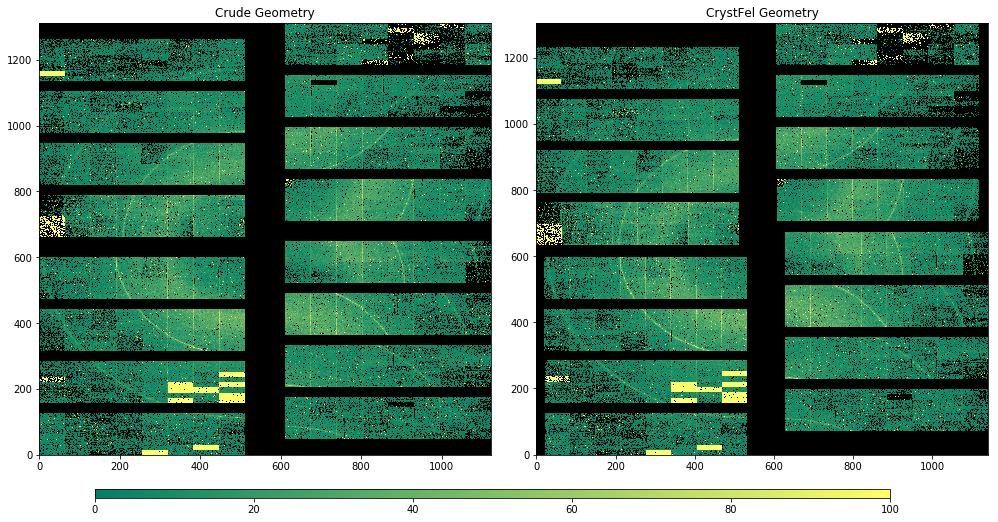

In [258]:
plot([np.flip(stack_mean[-1].T,axis=-1), np.nanmean(C.apply_geo(data), axis=0), np.nanmean(G.apply_geo(data), axis=0)], vmin=0, vmax=100)